<a href="https://colab.research.google.com/github/StoneMason495/cap-comp215/blob/main/COMP215Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prisoners Dilemma:
####By Zach Mason, COMP 215


The Prisoners Dilemma is a segment of game theory, the study of how and why people make certain decisions. The idea of the game is that two criminals are arrested, and placed into separate rooms for questioning. They have no way of communicating with one another

In [92]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

## Prisoner Class:

In [129]:
class Prisoner:
  #every possible combination of the 'opponents' last two moves, either ('C') cooperate with the other prisoner, or ('D') defect in the hope of a lesser sentence
  lasttwo_sims = [(None, None), #The none here means that less than two games of prisoners dilemma have been played
                  (None, 'C'),
                  (None, 'D'),
                  ('C', 'C'),
                  ('C', 'D'),
                  ('D', 'C'),
                  ('D', 'D')]

  def __init__(self, reactions, sentence=np.nan):
    self.reactions = reactions if type(reactions) == list else list(reactions)
    self.combinations = dict(zip(self.lasttwo_sims, reactions))
    self.sentence = sentence

  def reset(self):
    self.hist = [None, None]
    self.score = 0

  def mutate(self):
    '''Randomly select one element of the list to switch to the alternative choice (from 'C' to 'D' or vice versa)'''
    index = np.random.choice(len(self.reactions))
    self.reactions[index] = 'C' if self.reactions[index]== 'D' else 'D'
    return self.reactions

  def copy(self, p_mutation=0.05):
    '''Create a clone of the Prisoner, with a chance to change one of the elements to the alternate choice'''
    if random.random() > p_mutation:
      reactions = self.reactions
    else:
      reactions = self.mutate()
    return Prisoner(reactions)
  
  def past_responses(self, past=2):
    '''returns a tuple of the last two responses'''
    return (tuple(self.hist[-past:]))
  
  def respond(self, other):
    hist_key = other.past_responses()
    response = self.combinations[hist_key]
    return response

  def append(self, response, payoff):
    self.hist.append(response)
    self.score += payoff

  def random_agents(n_agents):
    agentlist = [Prisoner(np.random.choice(['C', 'D'], size = 7)) for i in range(n_agents)]
    return agentlist

  def identical_prisoners(n_prisoners, val):
    p_list = [Prisoner(val) for i in range (n_prisoners)]
    return p_list


In [94]:
agent = Prisoner.identical_prisoners(10, ('CCDCDCD'))
agent[3].combinations

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

## Metrics:

In [95]:
class Metric:
  def __init__(self):
    self.metrics = []

  def update(self, sim):
    pass

  def plot(self, **options):
    plt.plot(self.metrics, **options)

In [96]:
class MeanSentence(Metric):
  label = 'Mean Sentence'
  
  def update(self, sim):
    mean = np.nanmean(sim.get_sentences())
    self.metrics.append(mean)

In [97]:
class Cooperation(Metric):
  label = 'Cooperation Freq.'

  def update(self, sim):
    responses = np.array([p.reactions[0] for p in sim.prisoners])
    metric = np.mean(responses == 'C')
    self.metrics.append(metric)

## Tournament Class:

In [98]:
class PD_Tournament:
  payoffs = {('C', 'C'): (3, 3),
             ('C', 'D'): (0, 5),
             ('D', 'C'): (5, 0),
             ('D', 'D'): (1, 1)}
  num_rounds = 6

  def play(self, pri1, pri2):
    pri1.reset()
    pri2.reset()

    for i in range(self.num_rounds):
      pri1_resp = pri1.respond(pri2)
      pri2_resp = pri2.respond(pri1)

      pay1, pay2 = self.payoffs[pri1_resp, pri2_resp]

      pri1.append(pri1_resp, pay1)
      pri2.append(pri2_resp, pay2)

    return pri1.score, pri2.score

  def melee(self, agents, randomize=True):
    if randomize:
      agents = np.random.permutation(agents)

    n = len(agents)
    row_i = np.arange(n)
    row_j = (row_i + 1) % n

    totals = np.zeros(n)

    for i, j in zip(row_i, row_j):
      agent1, agent2 = agents[i], agents[j]
      score1, score2 = self.play(agent1, agent2)
      totals[i] += score1
      totals[j] += score2
    
    for i in row_i:
      agents[i].sentence = totals[i] / self.num_rounds / 2


In [99]:
agents = Prisoner.random_agents(10)
tour = PD_Tournament()
tour.melee(agents)
agents[5].sentence

2.8333333333333335

## Simulation Class:

In [124]:
class PD_Simulation:
  def __init__(self, tournament, prisoners):
    self.tournament = tournament
    self.prisoners = np.asarray(prisoners)
    self.metrics = []

  def add_metric(self, metric):
    self.metrics.append(metric)

  def get_sentences(self):
    sent = [prisoner.sentence for prisoner in self.prisoners]
    return np.array(sent)

  def step(self):
    self.tournament.melee(self.prisoners)

    n = len(self.prisoners)
    sent = self.get_sentences()
    
    index_gone = self.remove_prisoners(sent)
    num_gone = len(index_gone)

    replacements = self.replace_prisoners(num_gone, sent)
    self.prisoners[index_gone] = replacements

    self.update_metrics()

  def run(self, num_steps=500):

    for i in range(num_steps):
      self.step()

  def update_metrics(self):
    for metric in self.metrics:
        metric.update(self)

  def remove_prisoners(self, ps):
    n = len(self.prisoners)
    remove = np.random.random(n) < 0.1
    index_out = np.nonzero(remove)[0]
    return index_out

  def replace_prisoners(self, n, weights):
    prisoners = np.random.choice(self.prisoners, size=n, replace=True)
    replacements = [prisoner.copy() for prisoner in prisoners]
    return replacements


In [135]:
tourney = PD_Tournament()
prisoners = Prisoner.identical_prisoners(100, 'DDDDDDD')
# prisoners = Prisoner.random_agents(10)
sim = PD_Simulation(tourney, prisoners)
sim.add_metric(MeanSentence())
# sim.add_metric(Cooperation())
sim.run(5000)

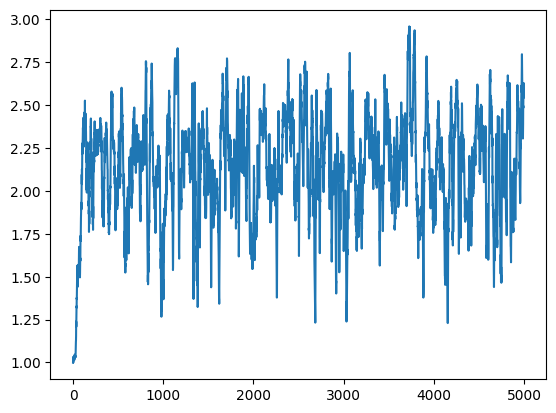

In [136]:
plt.plot(range(5000), sim.metrics[0].metrics)